In [1]:
import torch
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from alexNet_model_train import AlexNetFineTuner  # Import your AlexNet model class

In [2]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (AlexNet input size)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize with ImageNet means and stds
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [3]:
# Load CIFAR-10 dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use a subset for quick testing (optional)
from torch.utils.data import Subset
test_dataset = Subset(test_dataset, range(500))  # 100 samples for testing

test_dataloader = DataLoader(test_dataset, batch_size=32)


Files already downloaded and verified


In [4]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define pruning percentages
pruning_percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5]  # 0%, 10%, 20%, 30%

In [5]:
def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass through the model
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    all_preds_tensor = torch.tensor(all_preds)
    all_labels_tensor = torch.tensor(all_labels)
    return accuracy(all_preds_tensor, all_labels_tensor, task="multiclass", num_classes=10)

# List to store accuracies for each pruning percentage
accuracies = []

In [6]:
# Loop through each pruning percentage
for amount in pruning_percentages:
    # Reload the model from the checkpoint for each pruning level to start fresh
    checkpoint_path = "../checkpointsAlex/best-checkpoint.ckpt"  # Path to your saved checkpoint
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path)
    model.to(device)
    
    # Apply pruning if amount > 0
    if amount > 0:
        # Prune the weights of convolutional and linear layers
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name="weight", amount=amount)
                # Optionally, prune biases as well
                # prune.l1_unstructured(module, name="bias", amount=amount)
    
    # Evaluate and store accuracy
    test_accuracy = evaluate_model(model, test_dataloader)
    accuracies.append(test_accuracy.item())
    print(f"Test Accuracy after Pruning {amount*100:.0f}% of weights: {test_accuracy:.4f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy after Pruning 0% of weights: 0.8760
Test Accuracy after Pruning 10% of weights: 0.8800
Test Accuracy after Pruning 20% of weights: 0.8820
Test Accuracy after Pruning 30% of weights: 0.8760
Test Accuracy after Pruning 40% of weights: 0.8520
Test Accuracy after Pruning 50% of weights: 0.7500


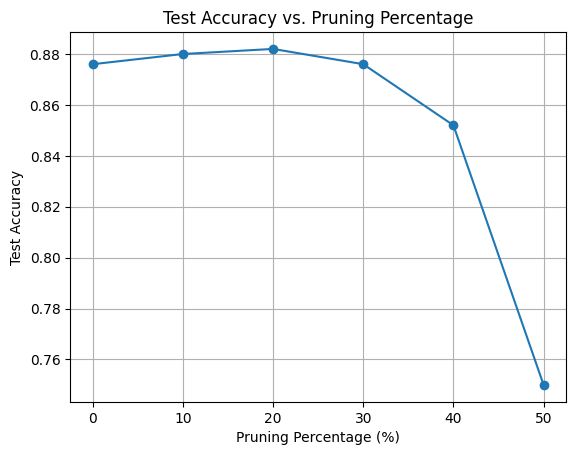

In [7]:
# Plot accuracy vs. pruning percentage
plt.plot([p * 100 for p in pruning_percentages], accuracies, marker='o')
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Pruning Percentage')
plt.grid(True)
plt.show()